In [18]:
# 导入相关包
import pandas as pd
import datetime as dt
import numpy as np
# 导入数据，查看用户交易明细数据
df = pd.read_csv('data/Retail_Data_Transactions.csv', parse_dates=['trans_date'], dayfirst = True)
# 查看前5条记录
df.head(5)

,customer_id,trans_date,tran_amount
0,CS4441,2015-01-24,984
1,CS5472,2014-05-18,206
2,CS7781,2013-12-01,466
3,CS7717,2015-12-18,782
4,CS8746,2012-12-30,372


In [19]:
# 查看用户营销响应数据
df2 = pd.read_csv('data/Retail_Data_Response.csv')
df2.head(5)

,customer_id,response
0,CS4441,1
1,CS5472,0
2,CS7781,1
3,CS7717,0
4,CS8746,1


In [20]:
# 准备数据（提取RFM特征）
print(df['trans_date'].min())
print(df['trans_date'].max())

2012-12-30 00:00:00
2015-12-31 00:00:00


In [21]:
# 设置当前时间now=2016-01-01
now = dt.datetime(2016,1,1)
# 在交易数据表中构造一个新变量hist,表示交易时间与当前时间的间隔天数
df['hist']=now - df['trans_date']

df['hist']=df['hist'] / np.timedelta64(1, 'D')
df.head()

,customer_id,trans_date,tran_amount,hist
0,CS4441,2015-01-24,984,342.0
1,CS5472,2014-05-18,206,593.0
2,CS7781,2013-12-01,466,761.0
3,CS7717,2015-12-18,782,14.0
4,CS8746,2012-12-30,372,1097.0


In [22]:
# 假设我们只分析过去2年的数据 , 筛选hist变量只小于730天的数据（最近2年）
df = df[df['hist']< 730]
df.count()

customer_id    1933
trans_date     1933
tran_amount    1933
hist           1933
dtype: int64

In [23]:
# 接下来我们将要对用户进行汇总（groupby），生成R，F，M特征变量。
rfmTable = df.groupby('customer_id').agg({'hist':'min','customer_id':'count','tran_amount':'sum'})
# 对变量重命名
rfmTable.rename(columns={'hist': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary'}, inplace=True)
rfmTable.head()

,recency,frequency,monetary
customer_id,,,
CS1000,217.0,1,64
CS1001,632.0,1,346
CS1008,256.0,1,526
CS1010,334.0,1,650
CS1020,516.0,1,832


In [24]:
# 对RFM变量进行简单的探索性分析
rfmTable.describe()

,recency,frequency,monetary
count,1742.000000,1742.000000,1742.000000
mean,356.308266,1.109644,538.561424
std,208.194963,0.335578,350.361340
min,1.000000,1.000000,10.000000
25%,177.000000,1.000000,245.000000
50%,353.000000,1.000000,517.000000
75%,535.000000,1.000000,791.500000
max,729.000000,3.000000,2044.000000


In [25]:
# 需要对RFM的值进行离散化后再分析，常见的方式是分为5个等分，
# 每个等分内接近20%的用户，即按照5等分的分位数来对RFM进行分段。
quantiles = rfmTable.quantile(q=[0.2,0.4,0.6,0.8])
quantiles

,recency,frequency,monetary
0.2,146.0,1.0,193.0
0.4,279.0,1.0,409.0
0.6,424.0,1.0,631.2
0.8,569.8,1.0,845.8


In [26]:
# 把quantiles的结果转为字典格式，便于后续分段时调用
quantiles=quantiles.to_dict()
quantiles

{'recency': {0.2: 146.0, 0.4: 279.0, 0.6: 424.0, 0.8: 569.8000000000002},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 193.0,
  0.4: 409.0,
  0.6: 631.1999999999998,
  0.8: 845.8000000000002}}

In [27]:
## for Recency 
def RClass(x,p,d):
    if x <= d[p][0.2]:
        return 5
    elif x <= d[p][0.4]:
        return 4
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 2
    else:
        return 1
## for Frequency and Monetary value 
def FMClass(x,p,d):
    if x <= d[p][0.2]:
        return 1
    elif x <= d[p][0.4]:
        return 2
    elif x <= d[p][0.6]: 
        return 3
    elif x <= d[p][0.8]: 
        return 4
    else:
        return 5

In [28]:
# 对R，F，M进行分段离散化处理
rfmSeg = rfmTable
rfmSeg['R_Seg'] = rfmSeg['recency'].apply(RClass, args=('recency',quantiles,))
rfmSeg['F_Seg'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSeg['M_Seg'] = rfmSeg['monetary'].apply(FMClass, args=('monetary',quantiles,))
rfmSeg.head()

,recency,frequency,monetary,R_Seg,F_Seg,M_Seg
customer_id,,,,,,
CS1000,217.0,1,64,4,1,1
CS1001,632.0,1,346,1,1,2
CS1008,256.0,1,526,4,1,3
CS1010,334.0,1,650,3,1,4
CS1020,516.0,1,832,2,1,4


In [29]:
# 把R，F，M三个变量的值组合成一个新的变量RFM
rfmSeg['RFMScore'] = rfmSeg.R_Seg.map(str) + rfmSeg.F_Seg.map(str) + rfmSeg.M_Seg.map(str)
rfmSeg.head()

,recency,frequency,monetary,R_Seg,F_Seg,M_Seg,RFMScore
customer_id,,,,,,,
CS1000,217.0,1,64,4,1,1,411
CS1001,632.0,1,346,1,1,2,112
CS1008,256.0,1,526,4,1,3,413
CS1010,334.0,1,650,3,1,4,314
CS1020,516.0,1,832,2,1,4,214


In [30]:
# 对用户的RFM分数值按照降序排列
rfmSeg.sort_values(by=['RFMScore', 'monetary'], ascending=[False, False]).head()

,recency,frequency,monetary,R_Seg,F_Seg,M_Seg,RFMScore
customer_id,,,,,,,
CS9223,30.0,2,1937,5,5,5,555
CS7487,6.0,2,1855,5,5,5,555
CS1055,11.0,3,1854,5,5,5,555
CS1492,75.0,2,1731,5,5,5,555
CS7791,62.0,2,1599,5,5,5,555


In [31]:
# 导入响应数据
response = pd.read_csv('data/Retail_Data_Response.csv')
response.sort_values('customer_id', inplace=True)
response.head()

,customer_id,response
2684,CS1000,1
989,CS1001,1
268,CS1008,1
2841,CS1010,1
2330,CS1011,1


In [32]:
rfmSeg.reset_index(inplace=True)
rfmSeg

,customer_id,recency,frequency,monetary,R_Seg,F_Seg,M_Seg,RFMScore
0,CS1000,217.0,1,64,4,1,1,411
1,CS1001,632.0,1,346,1,1,2,112
2,CS1008,256.0,1,526,4,1,3,413
3,CS1010,334.0,1,650,3,1,4,314
4,CS1020,516.0,1,832,2,1,4,214
...,...,...,...,...,...,...,...,...
1737,CS9978,34.0,1,859,5,1,5,515
1738,CS9990,720.0,1,906,1,1,5,115
1739,CS9992,269.0,2,1883,4,5,5,455
1740,CS9998,256.0,1,36,4,1,1,411


In [33]:
# 把rfmSeg和response按照customer_id连接在一张表中
rfmSeg.sort_values('customer_id', inplace=True)
rfm_response=pd.merge(rfmSeg, response, on='customer_id')
rfm_response.head()

,customer_id,recency,frequency,monetary,R_Seg,F_Seg,M_Seg,RFMScore,response
0,CS1000,217.0,1,64,4,1,1,411,1
1,CS1001,632.0,1,346,1,1,2,112,1
2,CS1008,256.0,1,526,4,1,3,413,1
3,CS1010,334.0,1,650,3,1,4,314,1
4,CS1020,516.0,1,832,2,1,4,214,1


Text(0, 0.5, 'Proportion of Responders')

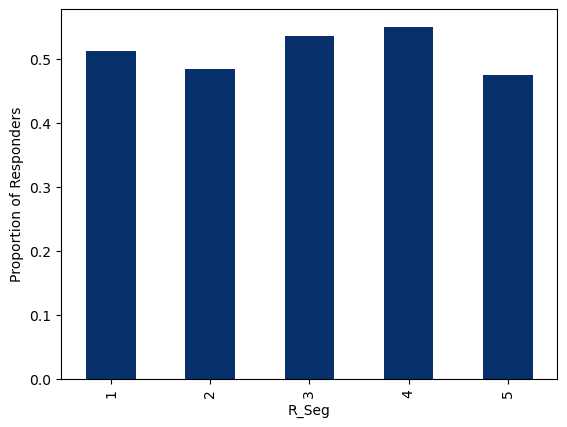

In [34]:
# 查看Recency与响应率的关系
%matplotlib inline 
ax=rfm_response.groupby('R_Seg').agg('response').mean().plot(kind='bar', colormap='Blues_r')
ax.set_xlabel("R_Seg")
ax.set_ylabel("Proportion of Responders")

Text(0, 0.5, 'Proportion of Responders')

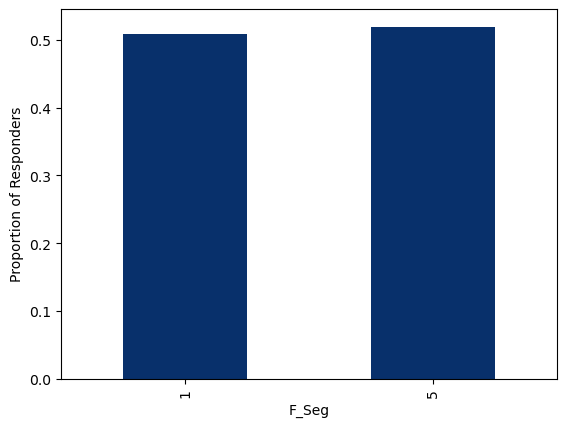

In [35]:
# 查看Frequency与响应率的关系
ax=rfm_response.groupby('F_Seg').agg('response').mean().plot(kind='bar', colormap='Blues_r')
ax.set_xlabel("F_Seg")
ax.set_ylabel("Proportion of Responders")

Text(0, 0.5, 'Proportion of Responders')

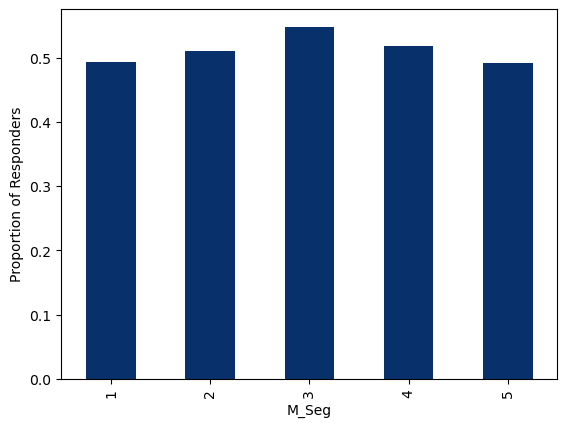

In [36]:
# Monetary与响应率的关系
ax=rfm_response.groupby('M_Seg').agg('response').mean().plot(kind='bar', colormap='Blues_r')
ax.set_xlabel("M_Seg")
ax.set_ylabel("Proportion of Responders")

In [37]:
# 构建一个营销响应模型

#准备数据集X,y 
from sklearn.model_selection import train_test_split
X = rfm_response[['recency','frequency','monetary']]
y = rfm_response['response']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)
# 模型训练 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [38]:
print(lr.coef_)
print(lr.intercept_)

[[9.12337016e-05 8.26882135e-02 2.33809724e-05]]
[-0.10795381]


In [39]:
# 分类评估报告
from sklearn.metrics import classification_report
# 对测试集X_test进行预测，得到y_pred
y_pred = lr.predict(X_test)
# 分类评估报告classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.48      0.14      0.22       307
           1       0.51      0.86      0.64       327

    accuracy                           0.51       634
   macro avg       0.50      0.50      0.43       634
weighted avg       0.50      0.51      0.44       634

